### Grassy Knoll

**Observations**

- Great Solar curves for Mar 17,18,19,20 (sunny, minimal clouds) perfect conditions for evaluating direct total component while minimizing diffuse component and maximizing direct component... can determine calibration corrections accross widest range of input voltage/irradiances.
- max solar zenith angle is only 45 degrees (limits impact of cosine contribution.  It is known that larger angles have decreased sensitivity.
- some dew on domes Monday (18) morning.  Evidenced in lw dataset (domes are not ventilated)
- dust/drops dried on domes evidenced tues morning.  did not clean any domes during 4 days

- spn1 with shade has largest signal and is relatively noisy at solar noon
- PSP38425 is lowest reading (is it out of spec? 40w/m^2 lower at solar noon than 38100 ~5%lower) morning and evening response not same... could be due to orientation or sighting
- shadows evident

- compare to UW instrument in UDistrict/Campus (which needs a 30min correction to time)
- compare to SOLRAD instruments on BLDG1 which have a solar tracker and NIP/PSP setup
- no knowledge of consistant cleaning for BLDG1 gear

- Choose PSP38100 as "Truth" as it is closest to newest SPN1 and in middle of data envelope

Data format really wants something more refined than a pandas csv read but with a lot of delimiters specified, it works... its not speedy though

In [2]:
import os
import glob #python >= 3.5

import datetime
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
### specify primary bulk figure parameters
fontsize = 20
labelsize = 16
#plotstyle = 'seaborn'
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [4]:
root_path = '/Users/bell/in_and_outbox/Ongoing_Analysis/ITAE_Projects/SPN1/2019_SailDrone_RadsIntercomparison/GrassyKnoll_PreSaildrone/'


In [5]:
swdata = {}
for filename in sorted(glob.iglob(root_path+'/*SW*.thin.txt', recursive=True), reverse=True):
    swdata.update({filename.split('/')[-1]: pd.read_csv(filename,header=None,
                                                        sep='"|,|SW Rn', engine='python',
                                                        usecols=[1,4],names=['time','sw'],
                                                        parse_dates=True,index_col='time')})
    

In [6]:
lwdata = {}
for filename in sorted(glob.iglob(root_path+'/*LW*.thin.txt', recursive=True), reverse=True):
    lwdata.update({filename.split('/')[-1]: pd.read_csv(filename,header=None,
                                                        sep='"|,|Rd|D|C|LW Rn', engine='python',
                                                        usecols=[1,4,6,8,10],names=['time','lwnet','c1','c2','lw'],
                                                        parse_dates=True,index_col='time')})

In [7]:
#be careful, dates near calendar day turn over sometimes are weird.  edit original file for clarity
spn1 = {}
for filename in sorted(glob.iglob(root_path+'/*A*.txt', recursive=True), reverse=True):
    spn1.update({filename.split('/')[-1]: pd.read_csv(filename,delimiter='\t',skiprows=4,
                                                      parse_dates=True,index_col='Time')})


In [8]:
#UW rad... needs 30min offset forward in time (done later in routine when timezone is addressed)
uwrad = {}
for filename in sorted(glob.iglob(root_path+'/*UW*.txt', recursive=True), reverse=True):
    uwrad.update({filename.split('/')[-1]: pd.read_csv(filename,delimiter='\s+',skiprows=71,usecols=[0,1,12],
                                                       names=['Date','Time','Radn'],
                                                      parse_dates=[['Date','Time']],index_col='Date_Time')})


In [9]:
#isus/solrad station on bldg1
solrad = {}
header=['year','jday','month','day','hour','min','dt','zen','dw_psp','direct','diffuse','uvb',
        'uvb_temp','qc_dwpsp','qc_direct','qc_diffuse','qc_uvb','qc_uvb_temp','std_dw_psp',
        'std_direct','std_diffuse','std_uvb']
def dateparse(x):
    return pd.datetime.strptime(x, '%Y %m %d %H %M')

for filename in sorted(glob.iglob(root_path+'/*sea*.dat', recursive=True), reverse=True):
    solrad.update({filename.split('/')[-1]: pd.read_csv(filename,delimiter='\s+',skiprows=2,header=None,names=header,
                                                        parse_dates=[['year','month','day','hour','min']],
                                                        index_col='year_month_day_hour_min', date_parser=dateparse)})


In [10]:
from pysolar.solar import *
import datetime

### example below
from dateutil import tz

solar_hypothetical = pd.DataFrame(columns=('Datetime', 'deg', 'rad','irr'))

for i in range(60*24):

    date = datetime.datetime(2019, 3, 18, 12, tzinfo=datetime.timezone.utc) + datetime.timedelta(minutes=i - 1)
    altitude_deg = get_altitude(47.6602, -122.3321, date)
    rad = radiation.get_radiation_direct(date, altitude_deg)
    irr = rad*np.cos(np.deg2rad(90-altitude_deg))
    solar_hypothetical.loc[i] = [date,altitude_deg,rad,irr]

solar_hypothetical = solar_hypothetical.set_index('Datetime')


solar_hypothetical['sza'] = np.nan
try:
    solar_hypothetical = solar_hypothetical.tz_localize('UTC')
except:
    solar_hypothetical = solar_hypothetical.tz_convert('UTC')


### Plot Timeseries of Each Instrument including temperatures

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


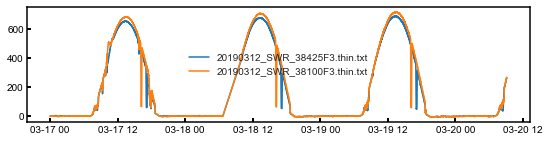

In [12]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in swdata.items():
    plt.plot(value,label=unit)

plt.legend()

plt.plot(solar_hypothetical.irr)
ax1.set_xlim(['2019-03-26 13','2019-03-27 03'])

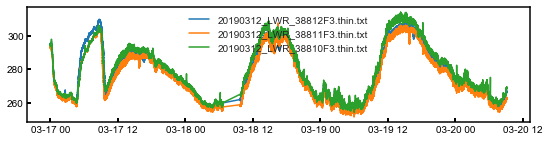

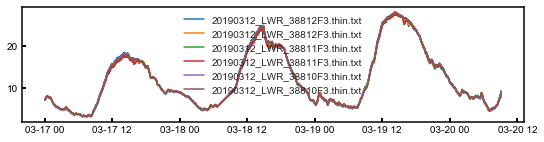

In [13]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in lwdata.items():
    plt.plot(value.lw,label=unit)

plt.legend()

fig = plt.figure(2,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in lwdata.items():
    plt.plot(value.c1,label=unit)
    plt.plot(value.c2,label=unit)

plt.legend()



### Difference Plots

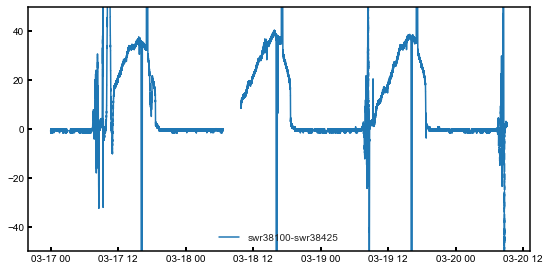

In [14]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38100F3.thin.txt']-swdata['20190312_SWR_38425F3.thin.txt'],label='swr38100-swr38425')
ax1.set_ylim([-50,50])

plt.legend()


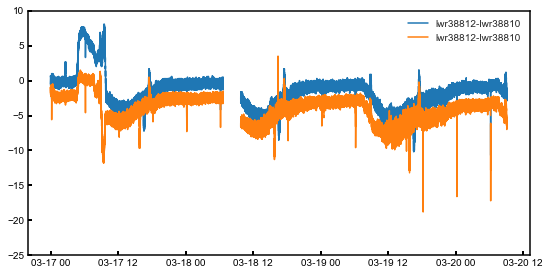

In [32]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(lwdata['20190312_LWR_38812F3.thin.txt'].lw-lwdata['20190312_LWR_38810F3.thin.txt'].lw,label='lwr38812-lwr38810')
plt.plot(lwdata['20190312_LWR_38811F3.thin.txt'].lw-lwdata['20190312_LWR_38810F3.thin.txt'].lw,label='lwr38812-lwr38810')
ax1.set_ylim([-25,10])
plt.legend()

### One-One Plots

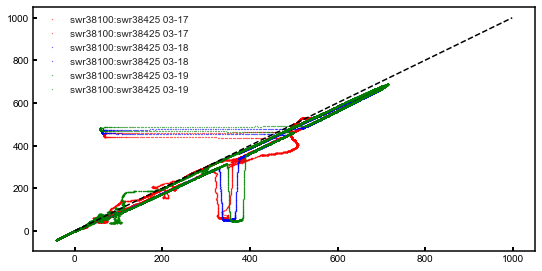

In [38]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17'].resample('1s').mean(),
         swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17'].resample('1s').mean(),
         '.r',markersize=.5,
         label='swr38100:swr38425 03-17')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18'].resample('1s').mean(),
         swdata['20190312_SWR_38425F3.thin.txt']['2019-03-18'].resample('1s').mean(),
         '.b',markersize=.5,
         label='swr38100:swr38425 03-18')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-19'].resample('1s').mean(),
         swdata['20190312_SWR_38425F3.thin.txt']['2019-03-19'].resample('1s').mean(),
         '.g',markersize=.5,
         label='swr38100:swr38425 03-19')
plt.plot(range(0,1000),range(0,1000),'k--')
plt.legend()


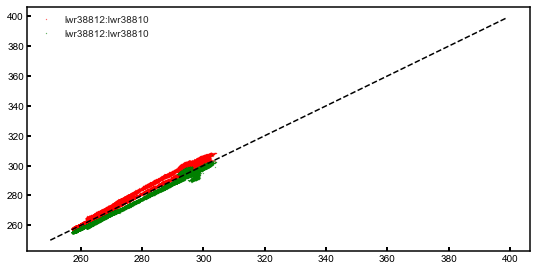

In [35]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(lwdata['20190312_LWR_38812F3.thin.txt']['2019-03-18']['lw'].resample('1s').mean(),
         lwdata['20190312_LWR_38810F3.thin.txt']['2019-03-18']['lw'].resample('1s').mean(),
         '.r',markersize=.5,
         label='lwr38812:lwr38810')
plt.plot(lwdata['20190312_LWR_38812F3.thin.txt']['2019-03-18']['lw'].resample('1s').mean(),
         lwdata['20190312_LWR_38811F3.thin.txt']['2019-03-18']['lw'].resample('1s').mean(),
         '.g',markersize=.5,
         label='lwr38812:lwr38810')
plt.plot(range(250,400),range(250,400),'k--')
plt.legend()


### Calculate SZA as this is more comparable paramter than irradiance

In [21]:
from pysolar.solar import *
import datetime

### example below
date = datetime.datetime.now(tz=datetime.timezone.utc)
print(get_altitude(42.206, -71.382, date))
date = datetime.datetime(2007, 2, 18, 15, 13, 1, 130320, tzinfo=datetime.timezone.utc)
print(get_altitude(42.206, -71.382, date))

39.09505969573679
30.91446827139096


In [22]:
### seattle, wa
lat = 47.6602
lon = -122.3321


In [75]:
for unit, value in swdata.items():
    count=0
    value['sza'] = np.nan
    try:
        value = value.tz_localize('UTC').tz_convert('US/Pacific')
    except:
        value = value.tz_convert('US/Pacific')
    for index, row in value.iterrows():
        value['sza'][index] = get_altitude(lat, lon, index)
        if (count % 3600) == 0:
            print(row)
        count+=1
        
    swdata[unit] = value

sw     -0.192000
sza   -40.798903
Name: 2019-03-17 00:00:00-07:00, dtype: float64
sw     -0.192000
sza   -43.596952
Name: 2019-03-17 01:00:00-07:00, dtype: float64
sw     -1.00800
sza   -42.84378
Name: 2019-03-17 01:59:59-07:00, dtype: float64
sw     -0.192000
sza   -38.704272
Name: 2019-03-17 02:59:59-07:00, dtype: float64
sw     -0.192000
sza   -31.950618
Name: 2019-03-17 03:59:59-07:00, dtype: float64
sw     -0.192000
sza   -23.465717
Name: 2019-03-17 04:59:59-07:00, dtype: float64
sw      0.624000
sza   -13.960418
Name: 2019-03-17 05:59:59-07:00, dtype: float64
sw     0.624000
sza   -3.960877
Name: 2019-03-17 06:59:58-07:00, dtype: float64
sw     50.394000
sza     6.260735
Name: 2019-03-17 07:59:58-07:00, dtype: float64
sw     193.993000
sza     15.962916
Name: 2019-03-17 08:59:58-07:00, dtype: float64
sw     333.513000
sza     24.971549
Name: 2019-03-17 09:59:58-07:00, dtype: float64
sw     529.330000
sza     32.661602
Name: 2019-03-17 10:59:58-07:00, dtype: float64
sw     601.945

In [93]:
for unit, value in spn1.items():
    count=0
    value['sza'] = np.nan
    try:
        value = value.tz_localize('UTC').tz_convert('US/Pacific')
    except:
        value = value.tz_convert('US/Pacific')
    spn1[unit] = value
    
for unit, value in uwrad.items():
    count=0
    value['sza'] = np.nan
    try:
        value = value.tz_localize('UTC').tz_convert('Etc/GMT+7')
        value.index = value.index+datetime.timedelta(seconds=1800)
    except:
        value = value.tz_convert('Etc/GMT+7')
        
    uwrad[unit] = value
    
for unit, value in solrad.items():
    count=0
    value['sza'] = np.nan
    try:
        value = value.tz_localize('UTC').tz_convert('Etc/GMT+7')
    except:
        value = value.tz_convert('Etc/GMT+7')
        
    solrad[unit] = value

In [25]:
#only need to calculate sza once really and wrt longwave its less a need
"""
for unit, value in lwdata.items():
    count=0
    value['sza'] = np.nan
    value = value.tz_localize('US/Pacific')
    for index, row in value.iterrows():
        value['sza'][index] = get_altitude(lat, lon, index)
        if (count % 3600) == 0:
            print(row)
        count+=1
        
    lwdata[unit] = value
"""

"\nfor unit, value in lwdata.items():\n    count=0\n    value['sza'] = np.nan\n    value = value.tz_localize('US/Pacific')\n    for index, row in value.iterrows():\n        value['sza'][index] = get_altitude(lat, lon, index)\n        if (count % 3600) == 0:\n            print(row)\n        count+=1\n        \n    lwdata[unit] = value\n"

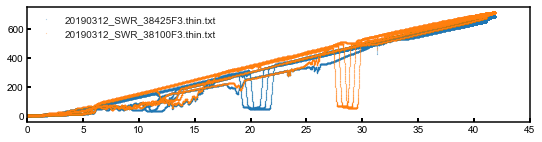

In [26]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in swdata.items():
    plt.plot(value.sza,value.sw,'.',markersize=.25,label=unit)
    
ax1.set_xlim([0,45])

plt.legend()


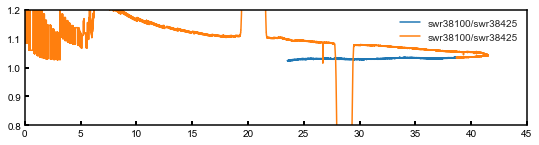

In [40]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38425F3.thin.txt']['2019-03-18 00:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sza,
         swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 00:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sw/swdata['20190312_SWR_38425F3.thin.txt']['2019-03-18 00:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sw,label='swr38100/swr38425')
plt.plot(swdata['20190312_SWR_38425F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sza,
         swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw/swdata['20190312_SWR_38425F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw,label='swr38100/swr38425')
ax1.set_xlim([0,45])
ax1.set_ylim([.8,1.2])

plt.legend()


### Load/Plot collocated SPN1's (2x)

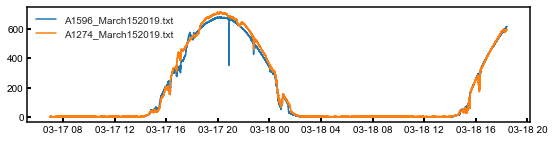

In [41]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in spn1.items():
    plt.plot(value.Total['2019-03-17':'2019-03-19'],label=unit)

plt.legend()


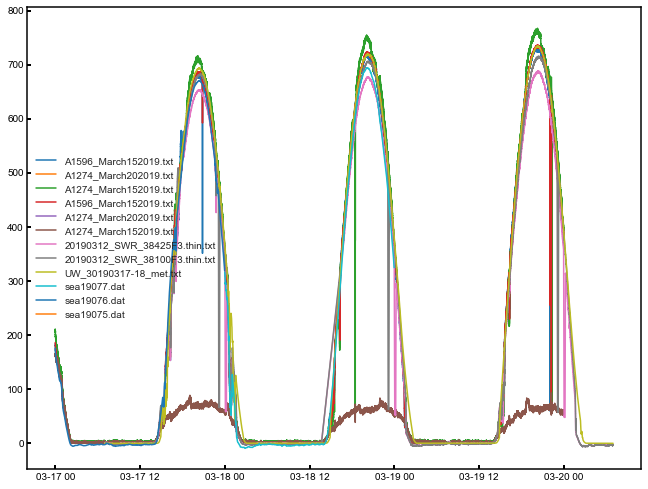

In [69]:
fig = plt.figure(1,figsize=(11,8.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in spn1.items():
    plt.plot(value.Total['2019-03-17':'2019-03-19'],label=unit)

for unit, value in spn1.items():
    plt.plot(value.Diffuse['2019-03-17':'2019-03-19'],label=unit)

for unit, value in swdata.items():
    plt.plot(value.sw['2019-03-17':'2019-03-19'],label=unit)

for unit, value in uwrad.items():
    plt.plot(value.Radn['2019-03-17':'2019-03-19'],label=unit)

for unit, value in solrad.items():
    plt.plot(value.dw_psp['2019-03-17':'2019-03-19'],label=unit)
   
plt.legend()


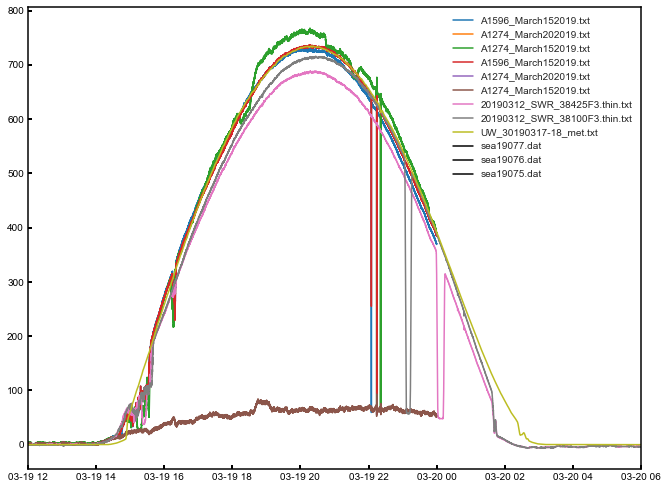

In [20]:
fig = plt.figure(1,figsize=(11,8.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in spn1.items():
    plt.plot(value.Total['2019-03-19':'2019-03-19'],label=unit)

for unit, value in spn1.items():
    plt.plot(value.Diffuse['2019-03-19':'2019-03-19'],label=unit)

for unit, value in swdata.items():
    plt.plot(value.index+datetime.timedelta(hours=7),value.sw,label=unit)

for unit, value in uwrad.items():
    plt.plot(value.index+datetime.timedelta(minutes=30),value.Radn,label=unit)

for unit, value in solrad.items():
    plt.plot(value.dw_psp['2019-03-19':'2019-03-19'],'k',label=unit)
    
ax1.set_xlim(['2019-03-19 12:00:00','2019-03-20 6:00:00'])
plt.legend()

fig.savefig('radcomp_20190319.png',dpi=300)

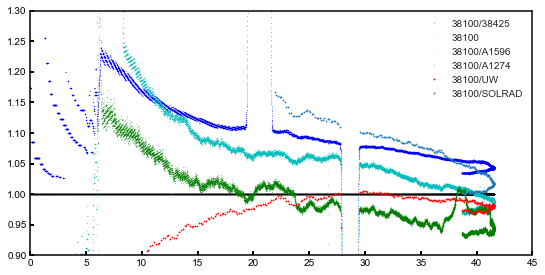

In [105]:
### Choose 38100 as truth (matches a recently cal'd spn1 and is in the middle of data envelope)

fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw/
         swdata['20190312_SWR_38425F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw),
         'b.',markersize=.25,label='38100/38425')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 12:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 12:00:00'].resample('1s').mean().sw/
         swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 12:00:00'].resample('1s').mean().sw),
         'k.',markersize=.125,label='38100')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw/
         spn1['A1596_March152019.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().Total),
         'c.',markersize=.25,label='38100/A1596')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw/
         spn1['A1274_March152019.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().Total),
         'g.',markersize=.25,label='38100/A1274')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw/
         uwrad['UW_30190317-18_met.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().Radn),
         'r.',markersize=1.5,label='38100/UW')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().sw/
         solrad['sea19077.dat']['2019-03-18 12:00:00':'2019-03-19 00:00:00'].resample('1s').mean().dw_psp),
         '.',markersize=1.5,label='38100/SOLRAD')
ax1.set_ylim([0.9,1.3])
ax1.set_xlim([0,45])

plt.legend()
plt.savefig('radcomp_offset_20190319.png',dpi=300)

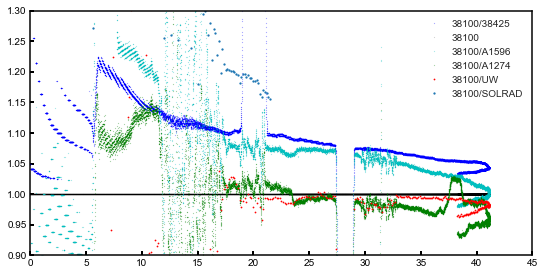

In [114]:
### Choose 38100 as truth (matches a recently cal'd spn1 and is in the middle of data envelope)

fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw),
         'b.',markersize=.25,label='38100/38425')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sw/
         swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sw),
         'k.',markersize=.125,label='38100')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         spn1['A1596_March152019.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().Total),
         'c.',markersize=.25,label='38100/A1596')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         spn1['A1274_March152019.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().Total),
         'g.',markersize=.25,label='38100/A1274')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         uwrad['UW_30190317-18_met.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().Radn),
         'r.',markersize=1.5,label='38100/UW')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         solrad['sea19077.dat']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().dw_psp),
         '.',markersize=2.5,label='38100/SOLRAD')
ax1.set_ylim([0.9,1.3])
ax1.set_xlim([0,45])

plt.legend()
plt.savefig('radcomp_offset_20190318.png',dpi=300)